In [19]:
import keras
import jax
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys
import optax
from flax.training.train_state import TrainState
from flax import linen as nn
from jax import numpy as jnp

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

In [6]:
x_train.dtype

dtype('float64')

In [97]:
x_train = jnp.array(x_train)
y_train = jnp.array(y_train)
x_test = jnp.array(x_test)
y_test = jnp.array(y_test)

x_train = x_train.astype(jnp.float32)
y_train = y_train.astype(jnp.float32)
x_test = x_test.astype(jnp.float32)
y_test = y_test.astype(jnp.float32)

In [98]:
# Data normalization
mean = x_train.mean()
std  = x_train.std()

x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

In [99]:
# Build a model

class SimpleModel(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(32)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(32)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [100]:
# initialize the model
model = SimpleModel()

In [101]:
# initialize the parameters
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, x_train.shape[1])))
# forward pass
y_pred = model.apply(params, jnp.ones((1, x_train.shape[1])))


In [102]:
y_pred.shape

(1, 1)

In [103]:
# optimizer
optimizer = optax.adam(1e-3)

In [104]:
model_state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [114]:
# loss function

def compute_loss(state,params, batch):
    x, y = batch
    y_pred = state.apply_fn(params, x)
    y_pred = y_pred.squeeze(axis=-1)
    loss = optax.huber_loss(y, y_pred)
    return loss.mean()

In [115]:
grad_fn = jax.value_and_grad(compute_loss, argnums=1)

In [116]:
@jax.jit
def train_step(state, batch):
    params = state.params
    loss, grads = grad_fn(state, params, batch)  # Pass params and batch to compute_loss
    state = state.apply_gradients(grads=grads)
    return state, loss

In [117]:
def train_model(state, X, y, epochs):
    for epoch in range(epochs):
        for i in range(0, X.shape[0], 32):
            batch = X[i:i+32], y[i:i+32]
            state, loss = train_step(state, batch)
            print(f'Epoch: {epoch}, Loss: {loss}')
    return state

In [118]:
a = train_model(model_state, x_train, y_train, 100)

Epoch: 0, Loss: 21.307422637939453
Epoch: 0, Loss: 19.470373153686523
Epoch: 0, Loss: 20.7613525390625
Epoch: 0, Loss: 23.482086181640625
Epoch: 0, Loss: 20.199249267578125
Epoch: 0, Loss: 21.098283767700195
Epoch: 0, Loss: 19.498401641845703
Epoch: 0, Loss: 19.662324905395508
Epoch: 0, Loss: 20.93280601501465
Epoch: 0, Loss: 22.702463150024414
Epoch: 0, Loss: 24.348915100097656
Epoch: 0, Loss: 22.650470733642578
Epoch: 0, Loss: 17.459671020507812
Epoch: 1, Loss: 19.906267166137695
Epoch: 1, Loss: 18.088207244873047
Epoch: 1, Loss: 19.333717346191406
Epoch: 1, Loss: 22.04688835144043
Epoch: 1, Loss: 18.648393630981445
Epoch: 1, Loss: 19.544719696044922
Epoch: 1, Loss: 17.86144256591797
Epoch: 1, Loss: 17.760147094726562
Epoch: 1, Loss: 19.19900131225586
Epoch: 1, Loss: 20.80632781982422
Epoch: 1, Loss: 22.3314266204834
Epoch: 1, Loss: 20.706546783447266
Epoch: 1, Loss: 15.289299011230469
Epoch: 2, Loss: 17.625173568725586
Epoch: 2, Loss: 15.814702033996582
Epoch: 2, Loss: 16.9676856994

Accuracy: 0.0


ValueError: x and y must be the same size

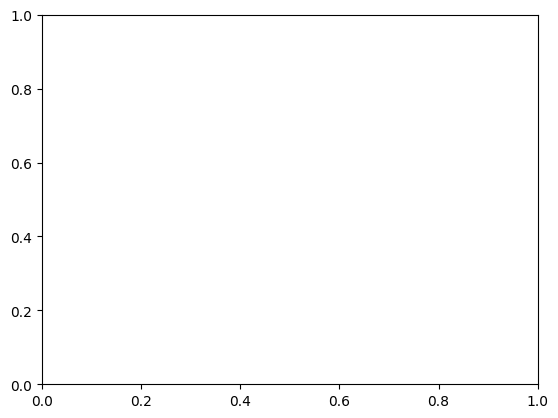

In [119]:
# validation
y_pred = model.apply(a.params, x_test)
y_pred = y_pred.squeeze(axis=-1)

accuracy = jnp.mean(jnp.equal(jnp.round(y_pred), y_test))
print(f'Accuracy: {accuracy}')

# plot the results
plt.scatter(x_train, y_train, color='blue', label='Training data')
plt.scatter(x_test, y_test, color='red', label='Testing data')
plt.plot(x_test, y_pred, color='green', label='Prediction')
plt.legend()

In [120]:
y_pred

Array([10.722138 , 19.42725  , 24.663485 , 20.010265 , 24.041296 ,
       21.879023 , 27.366358 , 25.452307 , 21.91969  , 18.953716 ,
       15.934058 , 20.042355 , 18.548935 , 25.72813  , 15.944087 ,
       24.428558 , 24.052418 , 22.462254 , 18.30008  , 18.547966 ,
       14.319642 , 15.468946 , 22.28722  , 22.015629 , 30.256128 ,
       20.065035 , 21.931374 , 33.056503 , 12.386196 , 24.198425 ,
       20.799313 , 13.080602 , 28.450933 , 23.822634 , 19.487286 ,
       13.871678 , 18.14181  , 18.297619 , 18.447134 , 30.932869 ,
       25.730795 , 22.448925 , 16.157398 , 24.145052 , 24.498777 ,
       24.08469  , 27.024237 , 21.410103 , 18.141937 , 23.530119 ,
       33.32302  , 22.102352 , 15.113429 , 19.787832 , 26.083714 ,
       24.166126 , 15.311354 , 24.955326 , 28.496162 , 23.3418   ,
       19.496094 , 16.265495 , 13.015538 , 21.048874 , 23.41771  ,
       30.085913 , 15.054398 , 28.426615 , 14.553073 , 13.472597 ,
       17.792564 , 25.958786 , 17.937502 , 15.4131155, 26.1322

In [121]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
            -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
            0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=jnp.array(my_data).reshape(1,13)

In [122]:
model.apply(a.params, my_data)

Array([[0.10177894]], dtype=float32)

In [125]:
model.describe

AttributeError: "SimpleModel" object has no attribute "describe". If "describe" is defined in '.setup()', remember these fields are only accessible from inside 'init' or 'apply'.